In [4]:
spark

Intitializing Scala interpreter ...

Spark Web UI available at http://localhost:4040
SparkContext available as 'sc' (version = 2.3.2, master = local[*], app id = local-1548760883140)
SparkSession available as 'spark'


res0: org.apache.spark.sql.SparkSession = org.apache.spark.sql.SparkSession@10382a9b


In [5]:
%run "src/scala/register_tables.scala"

In [6]:
%%python
import matplotlib.pyplot as plt
from src.python.helpers import plotfig_magic
import pandas as pd
import numpy as np
from IPython.display import Image
import tempfile

In [7]:
import org.apache.spark.mllib
import org.apache.spark.sql.functions
import org.apache.spark.sql.SparkSession
import spark.implicits._

import org.apache.spark.mllib
import org.apache.spark.sql.functions
import org.apache.spark.sql.SparkSession
import spark.implicits._


In [8]:
register_tables(spark,"spark-warehouse/")

===Prescription dataset===
registering patients
registering prescriptions
registering drugs
ok!
===Hospitalization dataset===
registering raw
registering patients
registering prescriptions
registering drugs
ok!
+--------+-----------------------------+-----------+
|database|tableName                    |isTemporary|
+--------+-----------------------------+-----------+
|        |hospitalization              |true       |
|        |hospitalization_drugs        |true       |
|        |hospitalization_patients     |true       |
|        |hospitalization_prescriptions|true       |
|        |prescription_drugs           |true       |
|        |prescription_patients        |true       |
|        |prescription_prescriptions   |true       |
+--------+-----------------------------+-----------+

done!


### Transformation from 5 to 4-level ATC codes

In [9]:
//UDFs for transformation from 5-level to 4-level ATC codes
val take4levelsUDF = udf( (x:String)=>x.slice(0,5) )

val df = spark.sql("select drugcode from hospitalization_prescriptions")

val df_4levels = df.select(take4levelsUDF(col("drugcode")).as("4L")).groupBy("4L").count
df_4levels.show
df_4levels.count
df_4levels.createOrReplaceTempView("ATC_4L")

+-----+------+
|   4L| count|
+-----+------+
|D06BX| 17413|
|N01BX|  2578|
|A02BX|  4026|
|QG03D|     7|
|V03AH|    22|
|N02AJ|999220|
|N04BA|241991|
|V04CL|    87|
|J01DH|   129|
|L02AA|     2|
|M05BB|  4682|
|G01AA|  4780|
|A06AD| 67895|
|A02BB|   780|
|G03DC|   218|
|L01XE| 10951|
|G04CA|458263|
|C07AA|163041|
|C09BB|  9282|
|A10AB| 85470|
+-----+------+
only showing top 20 rows



take4levelsUDF: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,StringType,Some(List(StringType)))
df: org.apache.spark.sql.DataFrame = [drugcode: string]
df_4levels: org.apache.spark.sql.DataFrame = [4L: string, count: bigint]


___ 
Our columns sum to 61.9M prescriptions (correct)

In [10]:
df_4levels.select(sum("count")).show

+----------+
|sum(count)|
+----------+
|  61925946|
+----------+



In [11]:
%%python
atc_4l = spark.sql("select * from ATC_4L where count>10000").toPandas()
print(atc_4l.shape)

(216, 2)


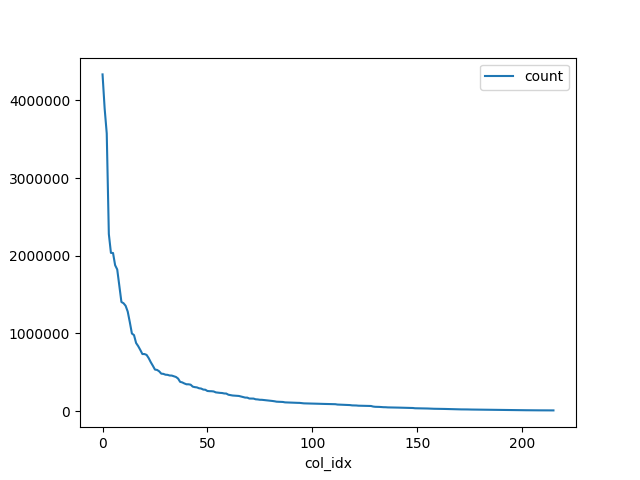

In [12]:
%%python
from src.python.helpers import plotfig_magic

atc_4l_sorted = atc_4l.sort_values(by=["count"], ascending=False)
atc_4l_sorted["col_idx"] = np.arange(0,atc_4l.shape[0])
#print(atc_4l_sorted[:20])
atc_4l_sorted.plot(x="col_idx",y="count")
retval = plotfig_magic()

# Encoding schemes
___

## One-Hot encoding of the 4L ATC codes
* We observe that taking 4 levels of the ATC hierarchy, and ignoring drugs that are prescribed less than 10000 times we get  _216_ unique 4-level drug codes
* Let's try to onehot encode these into a vector format using SPARK

In [36]:
import org.apache.spark.ml.feature.{OneHotEncoder, StringIndexer}
val df = spark.sql("select * from ATC_4L where count>10000").sort(asc("4L"))
df.count

import org.apache.spark.ml.feature.{OneHotEncoder, StringIndexer}
df: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [4L: string, count: bigint]
res24: Long = 216


In [37]:
//first we index the drugcodes
val indexer = new StringIndexer()
    .setInputCol("4L")
    .setOutputCol("4L_index")
    .fit(df)
val indexed = indexer.transform(df)

val encoder = new OneHotEncoder()
    .setInputCol("4L_index")
    .setOutputCol("4L_vec")

val encoded = encoder.transform(indexed)



indexer: org.apache.spark.ml.feature.StringIndexerModel = strIdx_391d399ae1f4
indexed: org.apache.spark.sql.DataFrame = [4L: string, count: bigint ... 1 more field]
encoder: org.apache.spark.ml.feature.OneHotEncoder = oneHot_aee8bace84d6
encoded: org.apache.spark.sql.DataFrame = [4L: string, count: bigint ... 2 more fields]


### Test how the encoder works

In [40]:
indexed.sort(asc("4L")).show

+-----+-------+--------+
|   4L|  count|4L_index|
+-----+-------+--------+
|A01AA|  30957|    18.0|
|A02AC|  11296|    46.0|
|A02AH|  34950|    54.0|
|A02BA| 201880|   145.0|
|A02BC|2037024|    21.0|
|A03AX|  19694|   157.0|
|A03FA| 143658|   129.0|
|A04AA|  35808|    43.0|
|A04AD|  10902|   215.0|
|A05AA|  11253|   127.0|
|A06AB| 162623|   131.0|
|A06AD|  67895|    92.0|
|A06AG|  11851|   151.0|
|A07AA|  45337|   106.0|
|A07DA|  79811|    61.0|
|A07EA|  17165|   183.0|
|A07EC|  78593|   108.0|
|A08AB|  14421|   146.0|
|A09AA|  48879|     4.0|
|A10AB|  85470|    37.0|
+-----+-------+--------+
only showing top 20 rows



In [15]:
import org.apache.spark.sql.SaveMode
encoded.select("*")
    .repartition(1).write
    .mode(SaveMode.Overwrite)
    .json(
        "spark-warehouse/preprocessing/TEST1HOTENCODEDSPARK"     
         )

import org.apache.spark.sql.SaveMode


In [16]:
encoded.show(5,false)
encoded.select("4L", "4L_vec").createOrReplaceTempView("encoded")

+-----+------+--------+-----------------+
|4L   |count |4L_index|4L_vec           |
+-----+------+--------+-----------------+
|D06BX|17413 |60.0    |(215,[60],[1.0]) |
|N02AJ|999220|153.0   |(215,[153],[1.0])|
|N04BA|241991|67.0    |(215,[67],[1.0]) |
|A06AD|67895 |92.0    |(215,[92],[1.0]) |
|L01XE|10951 |104.0   |(215,[104],[1.0])|
+-----+------+--------+-----------------+
only showing top 5 rows



In [17]:
%%python
df = spark.sql("select * from encoded").toPandas()

In [18]:
%python print(df[:10])

      4L                                             4L_vec
0  D06BX  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1  N02AJ  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2  N04BA  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3  A06AD  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4  L01XE  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5  G04CA  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6  C07AA  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7  A10AB  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8  N06AX  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9  A06AB  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [ ]:
%python 